In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# === Reproductibilité ===
import os, random, numpy as np
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)

# XGBoost / Sklearn: on passera random_state=42 partout où c'est possible
# Optuna: on fige aussi son sampler


In [3]:
from pathlib import Path
import pandas as pd

# Le notebook est dans /notebook → on remonte d’un cran
PROJ = Path.cwd().parent       # racine du projet
DATA = PROJ / "datasets"
MODELS = PROJ / "models"

print("Chemin datasets:", DATA.resolve())
print("Chemin models:", MODELS.resolve())

# Lecture
train_final = pd.read_csv(DATA / "train_final.csv")
test_final  = pd.read_csv(DATA / "test_final.csv")


Chemin datasets: C:\Users\yacin\Desktop\DATA SCIENCE OPENCLASSROOMS\Projet 8 MLOPS2\datasets
Chemin models: C:\Users\yacin\Desktop\DATA SCIENCE OPENCLASSROOMS\Projet 8 MLOPS2\models


In [4]:
train_final.shape

(307511, 598)

In [5]:
test_final.shape

(48744, 597)

## Fusion des données 

In [6]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

Pourquoi un seuil à 0.1 : Par défaut, le seuil est 0.5.
Mais dans ton projet, accorder un crédit à un mauvais client (FN) est très coûteux.

Donc, en abaissant le seuil à 0.1, tu dis :

    "Même si j’ai seulement 10% de certitude qu’un client est mauvais, je préfère le classer comme tel pour éviter une perte potentielle."

In [14]:
#XGBOOST

In [7]:
import os, json, joblib, numpy as np
from pathlib import Path
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    accuracy_score, confusion_matrix, classification_report
)
from xgboost import XGBClassifier

# ---------- Split ----------
X = train_final.drop(columns=["TARGET"])
y = train_final["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------- Coût métier & seuil ----------
def compute_business_cost(y_true, y_pred, fn_cost=10, fp_cost=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * fn_cost + fp * fp_cost

def find_best_threshold(y_true, y_probas, thresholds=np.linspace(0.1, 0.9, 81), fn_cost=10, fp_cost=1):
    best_t, best_cost = 0.5, float("inf")
    for t in thresholds:
        y_hat = (y_probas >= t).astype(int)
        c = compute_business_cost(y_true, y_hat, fn_cost, fp_cost)
        if c < best_cost:
            best_t, best_cost = t, c
    return best_t, best_cost

# ---------- Espace de recherche ----------
param_space_xgb = {
    "n_estimators": ("int", 80, 200),
    "max_depth": ("int", 3, 6),
    "learning_rate": ("float", 0.01, 0.2),
    "subsample": ("float", 0.6, 1.0),
    "colsample_bytree": ("float", 0.6, 1.0),
    "gamma": ("float", 0.0, 5.0),
    "reg_lambda": ("float", 0.001, 10.0),
    "reg_alpha": ("float", 0.001, 10.0),
    # Optionnel: aider le déséquilibre
    # "scale_pos_weight": ("float", 1.0, float((y_train==0).sum()/(y_train==1).sum()))
}


In [8]:
# ---------- Optuna (seedé) ----------
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)

def objective(trial):
    params = {
        k: (trial.suggest_int(k, *v[1:]) if v[0]=="int"
            else trial.suggest_float(k, *v[1:]) if v[0]=="float"
            else trial.suggest_categorical(k, v))
        for k, v in param_space_xgb.items()
    }
    # IMPORTANT: random_state figé
    model = XGBClassifier(
        use_label_encoder=False, eval_metric="logloss",
        random_state=42, **params
    )
    # Probas de CV sur le TRAIN (pas de fuite de test)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    y_cv_proba = cross_val_predict(
        model, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1
    )[:, 1]
    # On calcule le coût à un seuil "neutre" 0.5 pour comparer les params
    y_cv_pred = (y_cv_proba >= 0.5).astype(int)
    return compute_business_cost(y_train, y_cv_pred, fn_cost=10, fp_cost=1)

study.optimize(objective, n_trials=30)
best_params = study.best_params


[I 2025-09-01 12:23:20,660] A new study created in memory with name: no-name-7a956d02-f815-4f38-b22d-7c405261c225
[I 2025-09-01 12:23:54,409] Trial 0 finished with value: 190498.0 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.14907884894416698, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'reg_lambda': 0.5817780380698264, 'reg_alpha': 8.661895281603577}. Best is trial 0 with value: 190498.0.
[I 2025-09-01 12:24:35,870] Trial 1 finished with value: 198600.0 and parameters: {'n_estimators': 152, 'max_depth': 5, 'learning_rate': 0.013911053916202464, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'gamma': 1.0616955533913808, 'reg_lambda': 1.819067847103799, 'reg_alpha': 1.8348616940244846}. Best is trial 0 with value: 190498.0.
[I 2025-09-01 12:25:07,117] Trial 2 finished with value: 193740.0 and parameters: {'n_estimators': 116, 'max_depth': 5, 'learning_rate': 0.092069553542002,

In [9]:
# ---------- Fit final sur TRAIN ----------
best_model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss",
    random_state=42, **best_params
)
best_model.fit(X_train, y_train)

# ---------- Choix du SEUIL sur le TRAIN via CV (puis évaluation sur TEST) ----------
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
y_cv_proba = cross_val_predict(
    best_model, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]
best_threshold, _ = find_best_threshold(y_train, y_cv_proba, fn_cost=10, fp_cost=1)

# ---------- Évaluation sur TEST avec ce seuil ----------
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= best_threshold).astype(int)
business_cost = compute_business_cost(y_test, y_test_pred, fn_cost=10, fp_cost=1)

print(f"Seuil choisi (depuis CV sur train) : {best_threshold:.3f}")
print(f"Coût métier sur TEST : {business_cost}")
print("\nClassification report (TEST):\n")
print(classification_report(y_test, y_test_pred, digits=3))
print(f"ROC AUC (TEST): {roc_auc_score(y_test, y_test_proba):.3f}")


Seuil choisi (depuis CV sur train) : 0.100
Coût métier sur TEST : 31081

Classification report (TEST):

              precision    recall  f1-score   support

           0      0.959     0.792     0.867     56538
           1      0.205     0.611     0.307      4965

    accuracy                          0.777     61503
   macro avg      0.582     0.701     0.587     61503
weighted avg      0.898     0.777     0.822     61503

ROC AUC (TEST): 0.778


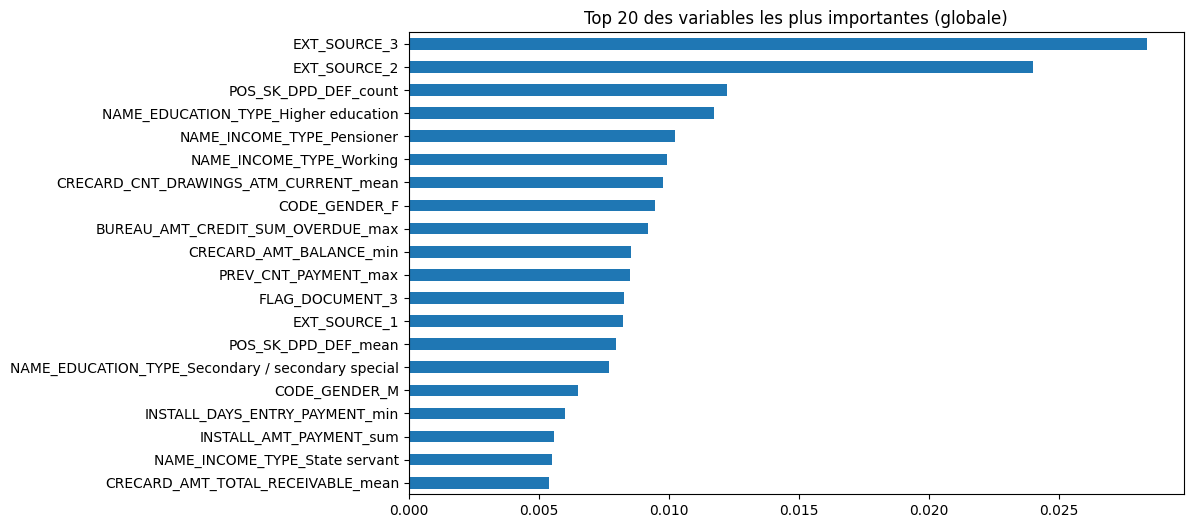

In [10]:
importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances_sorted.head(20).plot(kind='barh')
plt.title("Top 20 des variables les plus importantes (globale)")
plt.gca().invert_yaxis()
plt.show()

In [18]:
# ---------- Persistance des artefacts ----------
from pathlib import Path
MODELS = Path.cwd().parent / "models"
MODELS.mkdir(exist_ok=True, parents=True)

joblib.dump(best_model, MODELS / "best_model.pkl")

with open(MODELS / "features.txt", "w", encoding="utf-8") as f:
    for col in X_train.columns:
        f.write(col + "\n")

with open(MODELS / "threshold.json", "w", encoding="utf-8") as f:
    json.dump({"threshold": float(best_threshold)}, f)

with open(MODELS / "params.json", "w", encoding="utf-8") as f:
    json.dump(best_params, f, indent=2)

metrics = {
    "business_cost": float(business_cost),
    "f1": float(f1_score(y_test, y_test_pred)),
    "precision": float(precision_score(y_test, y_test_pred)),
    "recall": float(recall_score(y_test, y_test_pred)),
    "roc_auc": float(roc_auc_score(y_test, y_test_proba)),
    "accuracy": float(accuracy_score(y_test, y_test_pred))
}
with open(MODELS / "metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)


print("\n✅ Artefacts sauvegardés dans /models :")
print(" - best_model.pkl")
print(" - features.txt")
print(" - threshold.json")
print(" - params.json")
print(" - metrics.json")


✅ Artefacts sauvegardés dans /models :
 - best_model.pkl
 - features.txt
 - threshold.json
 - params.json
 - metrics.json


In [19]:
# ==== Inférence propre sur test_final avec chemins robustes ====
from pathlib import Path
import pandas as pd, json, joblib
import numpy as np

# 1) Définir les dossiers racine du projet
# Si ton notebook est dans /notebook, on remonte d'un cran.
PROJ = Path.cwd().parent          # <- si ton notebook est à la racine, mets: PROJ = Path.cwd()
DATA = PROJ / "datasets"
MODELS = PROJ / "models"

print("DATA  ->", DATA.resolve())
print("MODELS->", MODELS.resolve())

# 2) Charger les artefacts
model = joblib.load(MODELS / "best_model.pkl")
with open(MODELS / "threshold.json", "r", encoding="utf-8") as f:
    TH = json.load(f)["threshold"]
with open(MODELS / "features.txt", "r", encoding="utf-8") as f:
    feats = [l.strip() for l in f if l.strip()]

# 3) Charger le dataset d'inférence
test_path = DATA / "test_final.csv"
assert test_path.exists(), f"Fichier introuvable: {test_path}"
test_final = pd.read_csv(test_path)

# 4) Aligner les colonnes comme à l'entraînement
X_prod = test_final.drop(columns=["TARGET"], errors="ignore").copy()
missing = [c for c in feats if c not in X_prod.columns]
if missing:
    raise ValueError(f"Colonnes manquantes dans test_final: {missing}")
X_prod = X_prod[feats]

# 5) Prédire
proba = model.predict_proba(X_prod)[:, 1]
pred  = (proba >= TH).astype(int)

# 6) Sauvegarder les prédictions AU BON ENDROIT
out = test_final.copy()
out["score"] = proba
out["prediction"] = pred

pred_path = DATA / "predictions_test_final.csv"
out.to_csv(pred_path, index=False)

print("✅ predictions_test_final.csv créé.")
print("Chemin :", pred_path.resolve())
print(out.head())

✅ predictions_test_final.csv créé.
   SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0   -0.000003                 0.0           0.0              1.0   
1    0.000008                 0.0           0.0              1.0   
2    0.000031                 0.0           1.0              1.0   
3    0.000073                 0.0           0.0              1.0   
4    0.000101                 0.0           1.0              0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0      0.000000          0.000935    0.130787     0.073886         0.102132   
1      0.000000          0.000627    0.044387     0.061443         0.034792   
2      0.000000          0.001512    0.154373     0.265830         0.147026   
3      0.105263          0.002474    0.382022     0.184872         0.382716   
4      0.052632          0.001320    0.144944     0.118761         0.145903   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0 